In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Clear GPU cache
print(torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.empty_cache()
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, otherwise fallback to CPU

model_name = "meta-llama/Llama-3.1-8B-Instruct"  # Replace with exact path for 8B model

# Load the model with the appropriate device settings
model = AutoModelForCausalLM.from_pretrained(
    model_name,                   
    return_dict=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,     # Use float16 for efficient memory usage on GPU
    device_map="auto" if device == 0 else None,  # Automatically distribute across devices or use CPU
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

for name, param in model.named_parameters():
    print(f"{name} is on {param.device}")


True


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

model.embed_tokens.weight is on cuda:0
model.layers.0.self_attn.q_proj.weight is on cuda:0
model.layers.0.self_attn.k_proj.weight is on cuda:0
model.layers.0.self_attn.v_proj.weight is on cuda:0
model.layers.0.self_attn.o_proj.weight is on cuda:0
model.layers.0.mlp.gate_proj.weight is on cuda:0
model.layers.0.mlp.up_proj.weight is on cuda:0
model.layers.0.mlp.down_proj.weight is on cuda:0
model.layers.0.input_layernorm.weight is on cuda:0
model.layers.0.post_attention_layernorm.weight is on cuda:0
model.layers.1.self_attn.q_proj.weight is on cuda:0
model.layers.1.self_attn.k_proj.weight is on cuda:0
model.layers.1.self_attn.v_proj.weight is on cuda:0
model.layers.1.self_attn.o_proj.weight is on cuda:0
model.layers.1.mlp.gate_proj.weight is on cuda:0
model.layers.1.mlp.up_proj.weight is on cuda:0
model.layers.1.mlp.down_proj.weight is on cuda:0
model.layers.1.input_layernorm.weight is on cuda:0
model.layers.1.post_attention_layernorm.weight is on cuda:0
model.layers.2.self_attn.q_proj.w

In [2]:
import pandas as pd
import numpy as np
from time import time
import random
import matplotlib.pyplot as plt
    
    
# ----- llm label ----
llmname = 'llama'
label_df_org = pd.read_csv("../../data/post1080.csv")
label_df = label_df_org
fea_df = pd.read_csv("../../data/fea.csv")
# in pandas, select columns that name starts with "llama_" and ends with "01"
llm_columns = label_df.filter(regex=f'^{llmname}_.*01$')
# remove prefix llmname and suffix '01' from column names
llm_columns.columns = llm_columns.columns.str.replace(f'{llmname}_', '').str.replace('01', '')
# select columns whose names are in fea_df.fea
llm_columns = llm_columns.loc[:, llm_columns.columns.isin(fea_df.fea)]
# concat with label_df
label_df = pd.concat([label_df[['sm_id', 'raw_text']], llm_columns], axis=1)
label_df = label_df.set_index('sm_id', drop=False) # assign sm_id as row index
fea_df = fea_df.set_index('fea', drop=False)
# except column "raw_text"
label_df2 = label_df.copy()
label_df2 = label_df2.drop(columns=['raw_text'])
label_df3 = label_df.copy()
label_df3 = label_df3.drop(columns=['raw_text'])




# ----- human label ----
label_df_human = label_df_org
human_columns = label_df_human.filter(regex='^human_.*01$')
# remove prefix llmname and suffix '01' from column names
human_columns.columns = human_columns.columns.str.replace('human_', '').str.replace('01', '')
# select columns whose names are in fea_df.fea
human_columns = human_columns.loc[:, human_columns.columns.isin(fea_df.fea)]
# concat with label_df
label_df_human = pd.concat([label_df_human[['sm_id']], human_columns], axis=1)
label_df_human = label_df_human.set_index('sm_id', drop=False) # assign sm_id as row index

In [4]:
def plot_precision_recall(res_df):
    fig, ax = plt.subplots(1, 2)
    ax[0].bar(res_df.index, res_df['precision'], color='blue')
    ax[0].set_title("precision")  
    ax[0].set_xticks([])
    ax[1].bar(res_df.index, res_df['recall'], color='red')
    ax[1].set_title("recall")  
    ax[1].set_xticks([])
    plt.show()

def plot_precision_recall_diff(res_df, res_df_old):
    fig, ax = plt.subplots(1, 2)
    ax[0].bar(res_df.index, res_df['precision'] - res_df_old['precision'], color='blue')
    ax[0].set_title("precision")  
    ax[0].set_xticks([])
    ax[1].bar(res_df.index, res_df['recall'] - res_df_old['recall'], color='red')
    ax[1].set_title("recall")  
    ax[1].set_xticks([])
    plt.show()

def check_precision_recall(label_df, label_df_human, plot=True):
    res_df = pd.DataFrame(index=fea_df.fea, columns=['precision', 'recall'])

    for col in fea_df.fea:
        true_positives = (label_df.loc[:,col] == 1) & (label_df_human.loc[:,col] == 1)
        false_positives = (label_df.loc[:,col] == 1) & (label_df_human.loc[:,col] == 0)
        false_negatives = (label_df.loc[:,col] == 0) & (label_df_human.loc[:,col] == 1)
        precision = true_positives.sum() / (true_positives.sum() + false_positives.sum())
        recall = true_positives.sum() / (true_positives.sum() + false_negatives.sum())
        res_df.loc[col, 'precision'] = precision
        res_df.loc[col, 'recall'] = recall  
        
    if plot:
        plot_precision_recall(res_df)
    return res_df


pft = check_precision_recall(label_df, label_df_human)

In [6]:
system_message = """
You are an AI assistant designed to answer questions with the best of your knowledge.
Please restrict your answer to the exact question and use the exact answer format asked.
"""

def format_prompt(text, fea1, fea2, type="pos_neg"):
    fea_w_des1 = fea1 + " (" + str(fea_df.loc[fea1, 'description']) + ")"
    fea_w_des2 = fea2 + " (" + str(fea_df.loc[fea2, 'description']) + ")" 
    
    if type == "pos_neg":
        # engineer prompt for this 'pos_neg'pair
        prompt = f"In the provided paragraph, do you observe any strong association between topic '{fea_w_des1}' and topic '{fea_w_des2}'?\n"
        prompt += f"Respond in format: '[yes/no.] If yes, shortly describe the observed association. If no, only return no.'\n"
    
    if type == "pos_pos":
        # if fea 2 truly present in text, and fea2 is not inferred from fea1, putting the opposite of fea1 into the text, will give the same presence of fea2. 
        # inject the opposite instances of fea1 into the text
        fea1_oppo_examples = fea_df.loc[fea1, 'oppo_examples'].split(" (^_^) ")
        fea1_oppo_examples = random.sample(fea1_oppo_examples, 2)
        # random.shuffle(fea1_oppo_examples) # shuffle these examples
        text = text + " " + " ".join(fea1_oppo_examples[0:]) 
        prompt = f"Does the following paragraph mention '{fea_w_des2}'?\n"
        prompt += f"Respond in format: '[yes/no.] If yes, related phrases in the text. If no, only return no.'\n"
        
    
    paragragh_content = f"Paragraph: '{text}' \n"
    user_message = prompt + paragragh_content + "\n"
    
    return user_message

In [7]:
def get_pos_neg_matrix(sm_pos, sm_neg, raw_text):
    # create a matrix / table alike object, where rownames are sm_pos, colnames are sm_neg, and the cell value is the response from the LLM
    response_matrix = pd.DataFrame(index=sm_pos, columns=sm_neg)
    
    for i in range(len(sm_pos)): 
        pos_fea = sm_pos[i]
        
        for j in range(len(sm_neg)):
            neg_fea = sm_neg[j]

            # get user message
            user_message = format_prompt(raw_text, pos_fea, neg_fea, type="pos_neg")
            user_message = "Question: " + user_message + " Answer:"
            inputs = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": user_message}
                ],
                add_generation_prompt=False,
                return_dict=True,
                return_tensors="pt"
            )
            inputs.to(model.device)
            outputs = model.generate(**inputs,
                                     do_sample=True,
                                     max_new_tokens=512,
                                     temperature=0.1)
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            response = response.split("assistant\n\n")[-1]
            response = response.replace("[", "").replace("]", "")
            response = response.strip()
            response = response.lower()
            if response.startswith("no"):
                response = "no."
            response_matrix.loc[pos_fea, neg_fea] = response
            del inputs
            del outputs
        
    return response_matrix

def get_pos_pos_matrix(sm_pos, raw_text):
    response_matrix = pd.DataFrame(index=sm_pos, columns=sm_pos)
    for fea1 in sm_pos:
        for fea2 in sm_pos:
            if fea1 == fea2 : continue
            
            user_message = format_prompt(raw_text, fea1, fea2, type="pos_pos")
            user_message = "Question: " + user_message + " Answer:"
            inputs = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": user_message}
                ],
                add_generation_prompt=False,
                return_dict=True,
                return_tensors="pt"
            )
            inputs.to(model.device)
            outputs = model.generate(**inputs,
                                     do_sample=True,
                                     max_new_tokens=512,
                                     temperature=0.1)
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            response = response.split("assistant\n\n")[-1]
            response_matrix.loc[fea1, fea2] = response
            del inputs
            del outputs
    return response_matrix

Processing each post:   0%|          | 0/1080 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_to

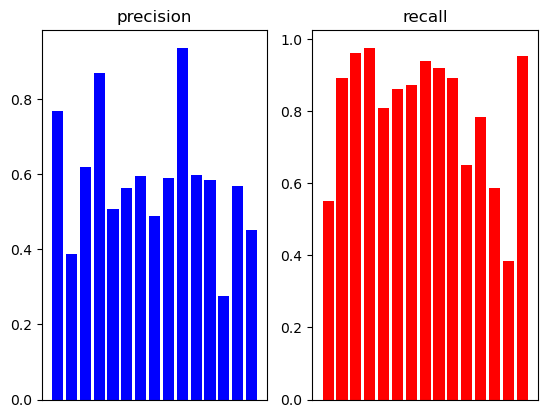

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

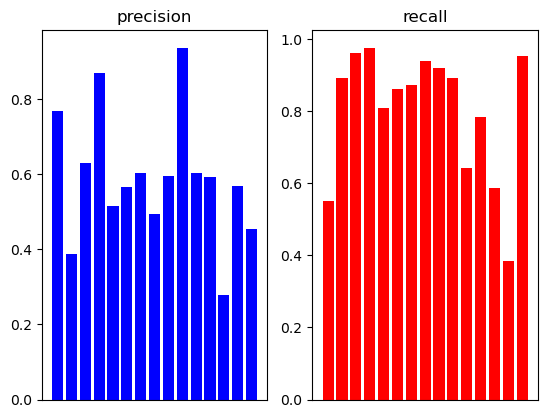

Processing each post:   1%|          | 10/1080 [03:13<8:17:20, 27.89s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Sett

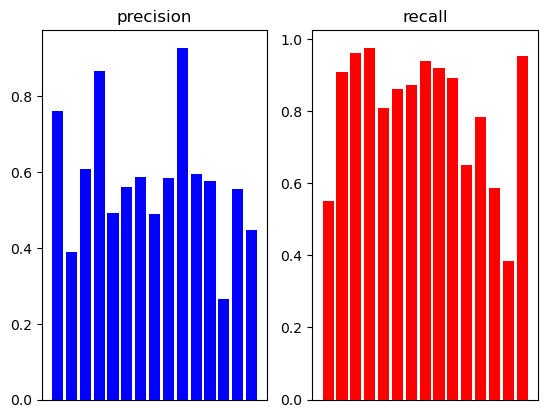

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

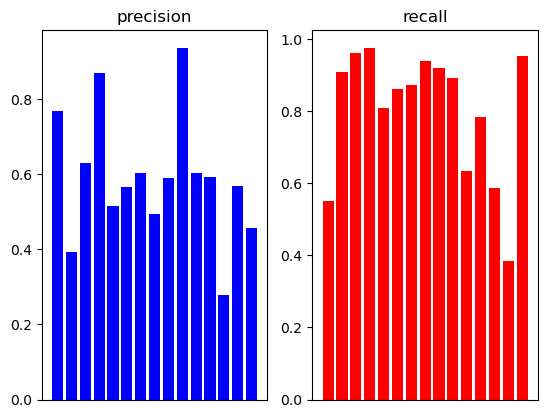

Processing each post:   2%|▏         | 20/1080 [11:11<17:06:45, 58.12s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Set

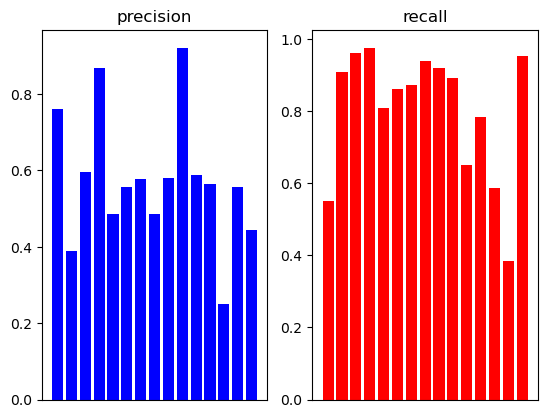

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

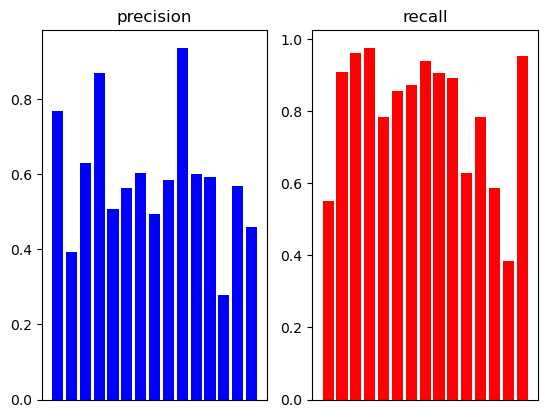

Processing each post:   3%|▎         | 30/1080 [18:23<12:49:14, 43.96s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Set

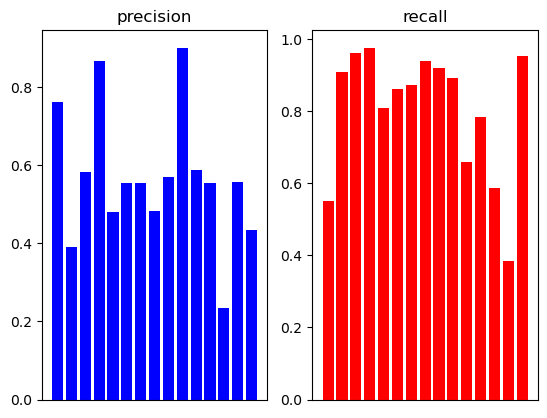

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

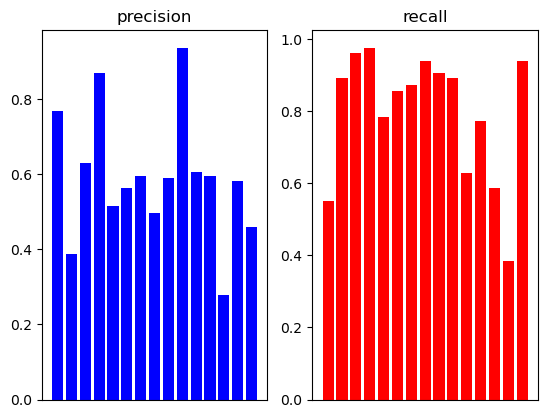

Processing each post:   4%|▎         | 40/1080 [26:29<22:33:30, 78.09s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Set

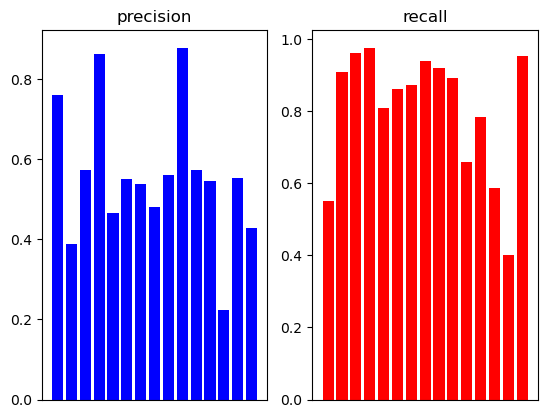

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


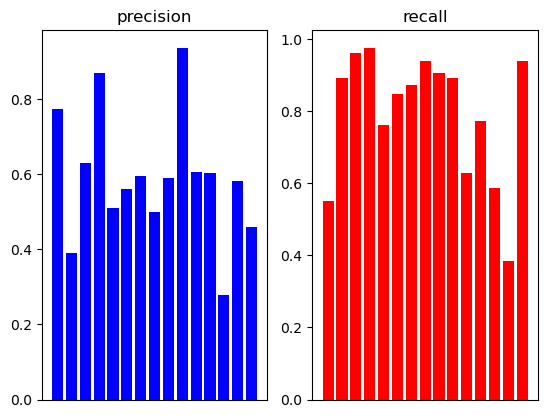

Processing each post:   5%|▍         | 50/1080 [34:45<10:30:57, 36.75s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Set

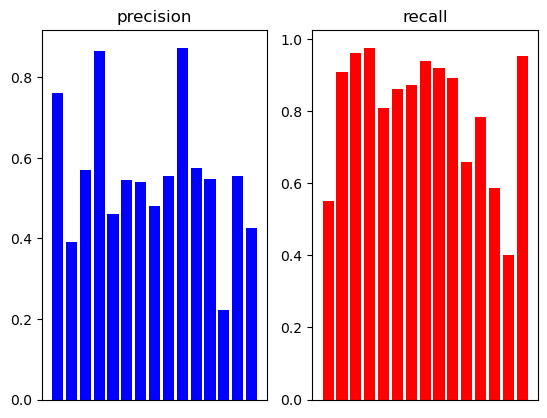

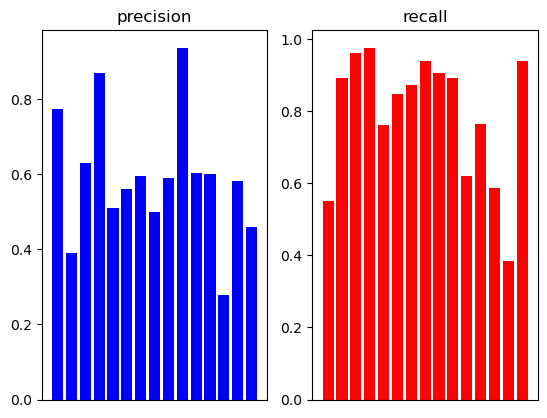

Processing each post:   6%|▌         | 60/1080 [37:27<6:59:33, 24.68s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Sett

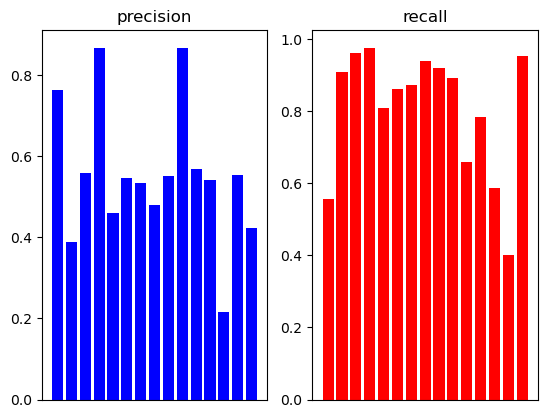

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

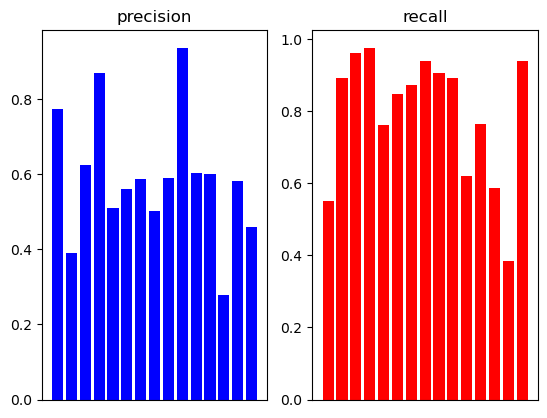

Processing each post:   6%|▋         | 70/1080 [42:17<9:01:20, 32.16s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Sett

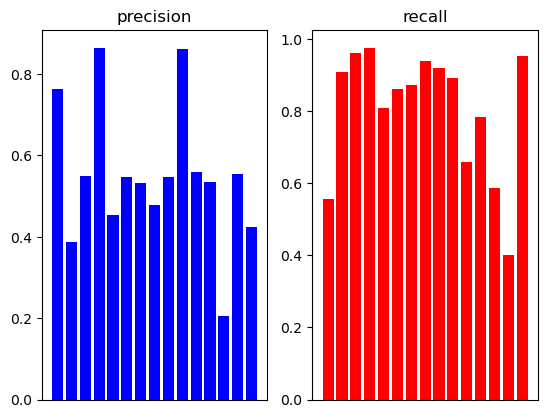

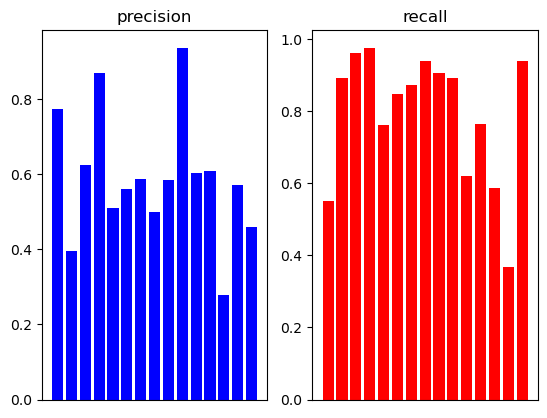

Processing each post:   7%|▋         | 80/1080 [46:39<4:51:54, 17.51s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Sett

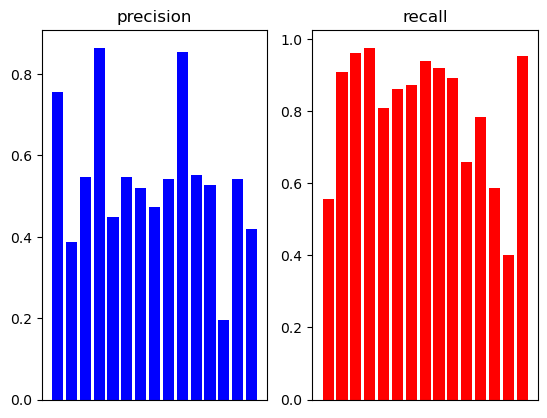

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

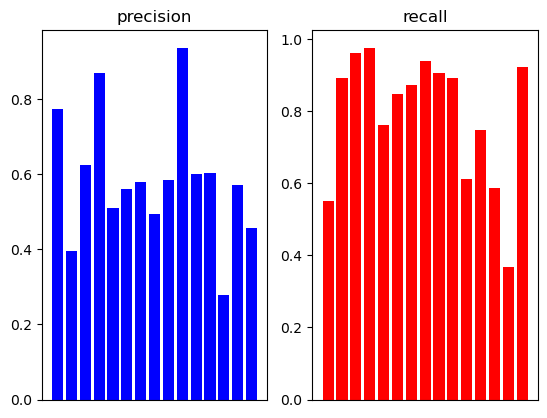

Processing each post:   8%|▊         | 90/1080 [53:14<9:52:03, 35.88s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
from tqdm import tqdm

count = 0
for sm_id in tqdm(label_df.index, desc="Processing each post") :# '1068zm3' is a good test sm_id
    count += 1
    # get the raw text of this sm_id
    raw_text = label_df.loc[sm_id, 'raw_text']
    
    # ----- 1. Detect potential false negatives -----
    # collect all positive labels for all features in fea_df.fea for this sm_id 
    sm_pos = [col for col in label_df.columns if col != 'raw_text' and label_df.loc[sm_id, col] == 1]
    # collect all negative labels for all features in fea_df.fea for this sm_id 
    sm_neg = [col for col in label_df.columns if col != 'raw_text' and label_df.loc[sm_id, col] == 0]
    # new postives
    new_pos = []
    if len(sm_pos) >= 1:
        sm_posneg_matrix = get_pos_neg_matrix(sm_pos, sm_neg, raw_text)
        sm_posneg_matrix = sm_posneg_matrix.transpose()
        sm_posneg_matrix['yes_ratio'] = sm_posneg_matrix.apply(lambda row: 1-row.value_counts().get('no.', 0) / len(row), axis=1)
        new_pos += sm_posneg_matrix[sm_posneg_matrix['yes_ratio'] > 0.5].index.tolist()
    if len(new_pos)>0:
        # store the result in 2nd shot label_df: label_df2
        for col in new_pos:
            label_df2.loc[sm_id, col] = 1
            label_df3.loc[sm_id, col] = 1
    pft_new = check_precision_recall(label_df2, label_df_human, plot=False)
    if count % 10 == 0:# plot for every 10 sm_id
        plot_precision_recall_diff(pft_new, pft)
        pft = pft_new
        
    # ----- 2. Detect potential false positives -----
    # collect all positive labels for all features in fea_df.fea for this sm_id 
    sm_pos = [col for col in label_df2.columns if col != 'raw_text' and label_df2.loc[sm_id, col] == 1]
    # new negatives
    new_neg = []
    if len(sm_pos) > 1:
        sm_pospos_matrix = get_pos_pos_matrix(sm_pos, raw_text)
        sm_pospos_matrix = sm_pospos_matrix.transpose()
        sm_pospos_matrix['no_ratio'] = sm_pospos_matrix.apply(lambda row: row.value_counts().get('no.', 0) / len(row), axis=1)
        new_neg += sm_pospos_matrix[sm_pospos_matrix['no_ratio'] > 0.5].index.tolist()
    if len(new_neg)>0:
        # store the result in 3rd shot label_df: label_df3
        for col in new_neg:
            label_df3.loc[sm_id, col] = 0
    pft_new = check_precision_recall(label_df3, label_df_human, plot=False)
    if count % 10 == 0:# plot for every 10 sm_id
        plot_precision_recall_diff(pft_new, pft)
        pft = pft_new
    

In [ ]:
label_df.to_csv("./post1080_1.csv", index=False)
label_df2.to_csv("./post1080_2.csv", index=False) 
label_df3.to_csv("./post1080_3.csv", index=False)

